# Fake News Classification with LSTM and Tensorflow

# [Link to my Youtube Video Explaining this whole Notebook](https://www.youtube.com/watch?v=VrJwKdls6d4&list=PLxqBkZuBynVTn2lkHNAcw6lgm1MD5QiMK&index=12)

[![Imgur](https://imgur.com/jRpFi37.png)](https://www.youtube.com/watch?v=VrJwKdls6d4&list=PLxqBkZuBynVTn2lkHNAcw6lgm1MD5QiMK&index=12)


## [Link to Dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter


from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet


from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

2022-08-21 15:44:58.218059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-21 15:44:58.218095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/paul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/paul/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/paul/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
glove_twitter = "../input/glove-twitter/glove.twitter.27B.100d.txt"

In [3]:
true_news = pd.read_csv("../input/fake-and-real-news-dataset/True.csv") 
# this folder structure works on both kaggle and local machine

fake_news = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")


In [4]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
true_news['news_class'], fake_news['news_class'] = 1, 0

news = pd.concat([true_news, fake_news])

In [7]:
news.head()

,title,text,subject,date,news_class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [8]:
news.info(memory_usage=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       44898 non-null  object
 1   text        44898 non-null  object
 2   subject     44898 non-null  object
 3   date        44898 non-null  object
 4   news_class  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [9]:
news.duplicated().sum()

209

In [10]:
news.drop_duplicates(inplace = True)

In [11]:
grouped_by_class = news.groupby('news_class').count()
grouped_by_class

,title,text,subject,date
news_class,,,,
0,23478,23478,23478,23478
1,21211,21211,21211,21211


In [12]:
news.isnull().sum()

title         0
text          0
subject       0
date          0
news_class    0
dtype: int64

In [13]:
news['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [14]:
news['title'].count()

44689

## EDA

In [15]:

x = news['news_class'].value_counts()
x

0    23478
1    21211
Name: news_class, dtype: int64

[Text(0.5, 1.0, 'Class Freq')]

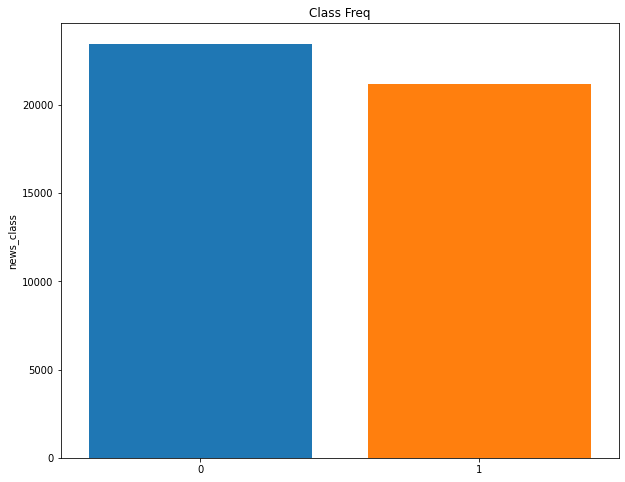

In [16]:
plt.figure(figsize= [ 10, 8] , clear = True, facecolor = 'white' )

sns.barplot(x = news['news_class'].value_counts().index,
            y = news['news_class'].value_counts(),
            saturation = 1).set(title  = 'Class Freq')
            

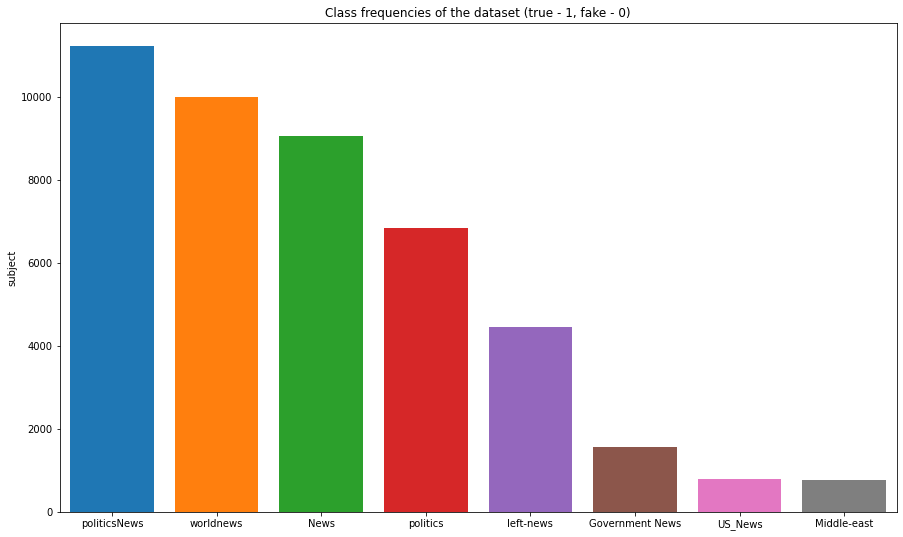

In [17]:
plt.figure(figsize = [15, 9], clear = True, facecolor = 'white')

sns.barplot(x = news["subject"].value_counts().index,
            y = news["subject"].value_counts(),
            saturation = 1).set(title = "Class frequencies of the dataset (true - 1, fake - 0)");

## Data Preprocessing before LSTM

In [18]:
news['text'] = news['text'] + " " + news['title']

news.drop(['title', 'date', 'subject' ], axis =1, inplace=True )



In [19]:
news.head()

,text,news_class
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [20]:
news['text'] = news['text'].apply(lambda x : " ".join(x.lower() for x in x.split() ) )


In [21]:
news.head()

,text,news_class
0,washington (reuters) - the head of a conservat...,1
1,washington (reuters) - transgender people will...,1
2,washington (reuters) - the special counsel inv...,1
3,washington (reuters) - trump campaign adviser ...,1
4,seattle/washington (reuters) - president donal...,1


In [22]:
news['text'] = news['text'].str.replace('[^\w\s]','')


In [23]:
news['text'] = news['text'].str.replace('\d', '' )

In [24]:
stop_words = set(stopwords.words('english'))
punctuation = list(string.punctuation)

stop_words.update(punctuation)

news['text'] = news['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words ) )

news.head()



,text,news_class
0,washington reuters head conservative republica...,1
1,washington reuters transgender people allowed ...,1
2,washington reuters special counsel investigati...,1
3,washington reuters trump campaign adviser geor...,1
4,seattlewashington reuters president donald tru...,1


In [27]:
news['text'] = news['text'].apply(lambda x : " ".join([Word(word).lemmatize() for word in x.split()]) )

In [28]:
news['text'] = news['text'].apply(lambda x : " ".join(re.sub(r'http\S+', '', x ) for x in x.split() ) )

In [29]:
news.head(n = 10).style.background_gradient(cmap = 'summer')

,text,news_class
0,washington reuters head conservative republican faction u congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint keeping sharp pivot way among republican u representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even november congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase nondefense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration already willing say going increase nondefense discretionary spending percent meadow chairman small influential house freedom caucus said program democrat saying thats enough need give government pay raise percent fiscal conservative dont see rationale eventually run people money said meadow among republican voted late december party debtfinanced tax overhaul expected balloon federal budget deficit add trillion year trillion national debt interesting hear mark talk fiscal responsibility democratic u representative joseph crowley said cbs crowley said republican tax bill would require united state borrow trillion paid future generation finance tax cut corporation rich one least fiscally responsible bill weve ever seen passed history house representative think going paying many many year come crowley said republican insist tax package biggest u tax overhaul year boost economy job growth house speaker paul ryan also supported tax bill recently went meadow making clear radio interview welfare entitlement reform party often call would top republican priority republican parlance entitlement program mean food stamp housing assistance medicare medicaid health insurance elderly poor disabled well program created washington assist needy democrat seized ryans early december remark saying showed republican would try pay tax overhaul seeking spending cut social program goal house republican may take back seat senate vote democrat needed approve budget prevent government shutdown democrat use leverage senate republican narrowly control defend discretionary nondefense program social spending tackling issue dreamer people brought illegally country child trump september put march expiration date deferred action childhood arrival daca program protects young immigrant deportation provides work permit president said recent twitter message want funding proposed mexican border wall immigration law change exchange agreeing help dreamer representative debbie dingell told cbs favor linking issue policy objective wall funding need daca clean said wednesday trump aide meet congressional leader discus issue followed weekend strategy session trump republican leader jan white house said trump also scheduled meet sunday florida republican governor rick scott want emergency aid house passed billion aid package hurricane florida texas puerto rico wildfire california package far exceeded billion requested trump administration senate yet voted aid u budget fight loom republican flip fiscal script,1
1,washington reuters transgender people allowed first time enlist u military starting monday ordered federal court pentagon said friday president donald trump administration decided appeal ruling blocked transgender ban two federal appeal court one washington one virginia last week rejected administration request put hold order lower court judge requiring military begin accepting transgender recruit jan justice department official said administration challenge ruling department defense announced releasing independent study issue coming week rather litigate interim appeal occurs administration decided wait dod study continue defend president lawful auth

Text(0.5, 1.0, 'Distribution of Text length for True News')

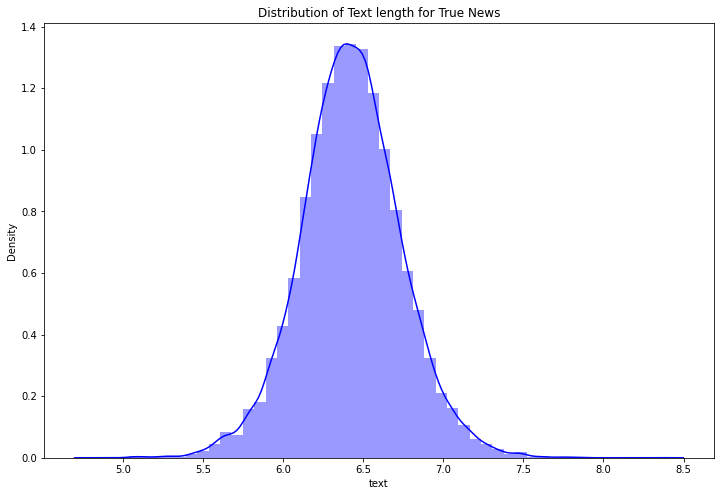

In [30]:
fix, ax = plt.subplots(figsize = (12, 8))

text_words = news[news['news_class'] == 1 ]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(text_words.map(lambda x : np.mean(x)), color = 'blue', ax = ax ).set_title('Distribution of Text length for True News')

Text(0.5, 1.0, 'Distribution of Text length for Fake News')

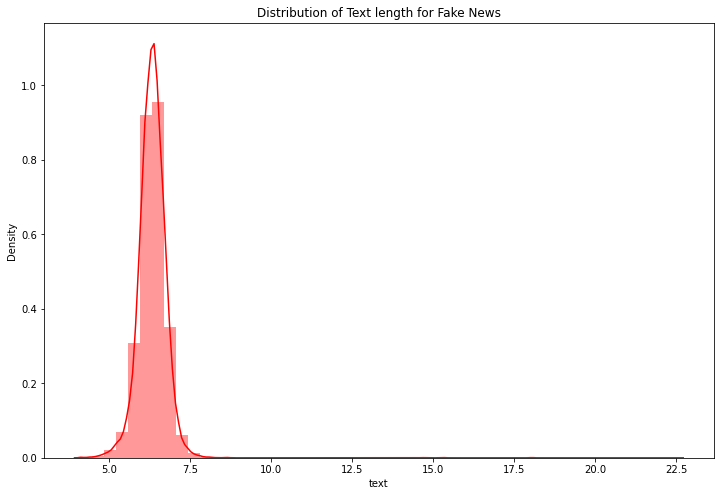

In [31]:
fix, ax = plt.subplots(figsize = (12, 8))

text_words = news[news['news_class'] == 0 ]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(text_words.map(lambda x : np.mean(x)), color = 'red', ax = ax ).set_title('Distribution of Text length for Fake News')

## Data preparation for LSTM

In [32]:
x = news['text']

y = news['news_class']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, shuffle = True, random_state=11 )

In [33]:
print(train_x.shape, test_x.shape)

(33516,) (11173,)


In [34]:
tokenizer = Tokenizer(num_words = 10000)

tokenizer.fit_on_texts(train_x)


tokenized_train = tokenizer.texts_to_sequences(train_x)

tokenized_train = tokenizer.texts_to_sequences(test_x)

`word_index["the"] = 1; word_index["cat"] = 2`

In [35]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = "float32")


embeddings_index = dict(get_coefs(*g.rstrip().rsplit(" ")) for g in open(glove_twitter))

embeddings_index

{'<user>': array([ 0.63006  ,  0.65177  ,  0.25545  ,  0.018593 ,  0.043094 ,
         0.047194 ,  0.23218  ,  0.11613  ,  0.17371  ,  0.40487  ,
         0.022524 , -0.076731 , -2.2911   ,  0.094127 ,  0.43293  ,
         0.041801 ,  0.063175 , -0.64486  , -0.43657  ,  0.024114 ,
        -0.082989 ,  0.21686  , -0.13462  , -0.22336  ,  0.39436  ,
        -2.1724   , -0.39544  ,  0.16536  ,  0.39438  , -0.35182  ,
        -0.14996  ,  0.10502  , -0.45937  ,  0.27729  ,  0.8924   ,
        -0.042313 , -0.009345 ,  0.55017  ,  0.095521 ,  0.070504 ,
        -1.1781   ,  0.013723 ,  0.17742  ,  0.74142  ,  0.17716  ,
         0.038468 , -0.31684  ,  0.08941  ,  0.20557  , -0.34328  ,
        -0.64303  , -0.878    , -0.16293  , -0.055925 ,  0.33898  ,
         0.60664  , -0.2774   ,  0.33626  ,  0.21603  , -0.11051  ,
         0.0058673, -0.64757  , -0.068222 , -0.77414  ,  0.13911  ,
        -0.15851  , -0.61885  , -0.10192  , -0.47     ,  0.19787  ,
         0.42175  , -0.18458  ,  0.080

In [ ]:
tokenizer.word_index.items()


In [ ]:
embedding = np.stack(embeddings_index.values())

embedding_mean, embedding_std = embedding.mean(), embedding.std()

embedding_size = embedding.shape[1]

word_index = tokenizer.word_index

nb_word = min(10000, len(word_index) )



In [ ]:
embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_word, embedding_size) )

for word, i in word_index.items():
    if i >= 10000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, factor = 0.5, min_lr = 0.00001 )

In [ ]:
model = Sequential()

model.add(Embedding(10000, output_dim=100, weights = [embedding_matrix], input_length=300, trainable = False ))

model.add(LSTM(units = 128, return_sequences=True, recurrent_dropout=0.3, dropout = 0.3))

model.add(LSTM(units = 64, recurrent_dropout = 0.15,
               dropout = 0.15))

model.add(Dense(units = 32, activation= 'relu' ))

model.add(Dense(1, activation = 'sigmoid' ))

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001), loss = 'binary_crossentropy', metrics=['accuracy'] )



In [ ]:
model.summary()

In [ ]:
history = model.fit(train_x, train_y, batch_size=128, validation_data = (test_x, test_y), epochs = 10, 
                    callbacks = [lr_reduce]
                    )

In [ ]:
epochs = [i for i in range(10)]

fig, ax = plt.subplots(1, 2)

train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy' )
ax[0].plot(epochs, val_acc, 'go-', label = 'Test Accuracy' )
ax[0].set_title('Train and Test Accuracy across Epochs')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy Scores')


ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss' )
ax[1].plot(epochs, val_loss, 'go-', label = 'Test Loss' )
ax[1].set_title('Train and Test Loss across Epochs')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Losses')




In [ ]:
predictions = model.predict(test_x)

classes_pred = np.argmax(predictions, axis = 1)

print(classification_report(test_y, classes_pred))